In [1]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from collections import Counter
from tensorflow.keras.layers import Dense

In [2]:
def load_images(root_dir, img_size=(224, 224)):
    X, y = [], []
    class_counts = Counter()

    class_mapping = {
        'cardboard': 1,
        'glass': 1,
        'metal': 1,
        'plastic': 1,
        'paper': 1,
        'trash': 0
    }
    for category in ['recyclable', 'non_recyclable']:
        category_path = os.path.join(root_dir, category)

        for subfolder in os.listdir(category_path):
            subfolder_path = os.path.join(category_path, subfolder)
            if not os.path.isdir(subfolder_path):
                continue
                
            material = subfolder.lower()
            label = class_mapping.get(material, 0 if category == 'non_recyclable' else 1)
            
            for file in os.listdir(subfolder_path):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(subfolder_path, file)
                    try:
                        img = Image.open(img_path).convert('RGB').resize(img_size)
                        X.append(np.array(img))
                        y.append(label)
                        class_counts[material] += 1
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")
    print("\nClass distribution:")
    for cls, count in class_counts.items():
        print(f"{cls}: {count} images")
    
    return np.array(X), np.array(y)

In [3]:
X, y = load_images("E:/Codes/Garbage Classification/dataset-resized")
print(f"\nTotal loaded images: {len(X)}")

class_counts = np.bincount(y)
total = len(y)
class_weights = {0: total/(2*class_counts[0]), 1: total/(2*class_counts[1])}
print(f"\nClass weights: {class_weights}")


Class distribution:
cardboard: 403 images
glass: 501 images
metal: 410 images
paper: 594 images
plastic: 482 images
trash: 137 images

Total loaded images: 2527

Class weights: {0: 9.222627737226277, 1: 0.5286610878661088}


In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

In [5]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

In [6]:
def augment(image, label):
    image = tf.cast(image, tf.float32)
    
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if tf.random.uniform(()) > 0.5:
        k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k=k)
    
    image = tf.image.random_brightness(image, max_delta=32.)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)
    image = tf.image.random_hue(image, max_delta=0.04)
    
    if tf.random.uniform(()) > 0.5:
        h = tf.shape(image)[0]
        w = tf.shape(image)[1]
        c = tf.shape(image)[2]
        
        zoom_factor = tf.random.uniform(shape=[], minval=0.8, maxval=1.0)
        h_new = tf.cast(tf.cast(h, tf.float32) * zoom_factor, tf.int32)
        w_new = tf.cast(tf.cast(w, tf.float32) * zoom_factor, tf.int32)
        
        size = tf.stack([h_new, w_new, c])
        image = tf.image.random_crop(image, size=size)
        image = tf.image.resize(image, size=[h, w])
    
    image = tf.clip_by_value(image, 0., 255.)
    image = tf.cast(image, tf.uint8)
    
    return image, label

In [7]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

train_ds = (train_ds
            .shuffle(1000, reshuffle_each_iteration=True)
            .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
            .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(32)
            .prefetch(tf.data.AUTOTUNE))
val_ds = (val_ds
          .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
          .batch(32)
          .prefetch(tf.data.AUTOTUNE))

In [8]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
num_classes = 6
outputs = Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [9]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2)
]

In [10]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/15
64/64 [==============================] - 303s 5s/step - loss: 0.9516 - accuracy: 0.7006 - val_loss: 0.4525 - val_accuracy: 0.8162 - lr: 0.0010
Epoch 2/15
64/64 [==============================] - 359s 6s/step - loss: 0.4111 - accuracy: 0.8506 - val_loss: 0.4496 - val_accuracy: 0.8043 - lr: 0.0010
Epoch 3/15
64/64 [==============================] - 270s 4s/step - loss: 0.3932 - accuracy: 0.8595 - val_loss: 0.4281 - val_accuracy: 0.7964 - lr: 0.0010
Epoch 4/15
64/64 [==============================] - 278s 4s/step - loss: 0.2880 - accuracy: 0.8699 - val_loss: 0.1881 - val_accuracy: 0.9308 - lr: 0.0010
Epoch 5/15
64/64 [==============================] - 329s 5s/step - loss: 0.2461 - accuracy: 0.8981 - val_loss: 0.1471 - val_accuracy: 0.9427 - lr: 0.0010
Epoch 6/15
64/64 [==============================] - 276s 4s/step - loss: 0.2380 - accuracy: 0.9124 - val_loss: 0.3343 - val_accuracy: 0.8518 - lr: 0.0010
Epoch 7/15
64/64 [==============================] - 271s 4s/step - loss: 0.2

In [12]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/10
64/64 [==============================] - 458s 7s/step - loss: 0.2243 - accuracy: 0.9055 - val_loss: 0.2090 - val_accuracy: 0.9269 - lr: 1.0000e-05
Epoch 2/10
64/64 [==============================] - 428s 7s/step - loss: 0.2042 - accuracy: 0.9208 - val_loss: 0.1845 - val_accuracy: 0.9328 - lr: 1.0000e-05
Epoch 3/10
64/64 [==============================] - 423s 7s/step - loss: 0.1845 - accuracy: 0.9332 - val_loss: 0.2328 - val_accuracy: 0.9071 - lr: 1.0000e-05
Epoch 4/10
64/64 [==============================] - 414s 6s/step - loss: 0.1395 - accuracy: 0.9421 - val_loss: 0.1440 - val_accuracy: 0.9447 - lr: 1.0000e-05
Epoch 5/10
64/64 [==============================] - 424s 7s/step - loss: 0.1120 - accuracy: 0.9530 - val_loss: 0.1457 - val_accuracy: 0.9486 - lr: 1.0000e-05
Epoch 6/10
64/64 [==============================] - 465s 7s/step - loss: 0.1230 - accuracy: 0.9510 - val_loss: 0.1637 - val_accuracy: 0.9447 - lr: 1.0000e-05
Epoch 7/10
64/64 [==============================] - 


📊 Training plots saved as 'training_plots.png'


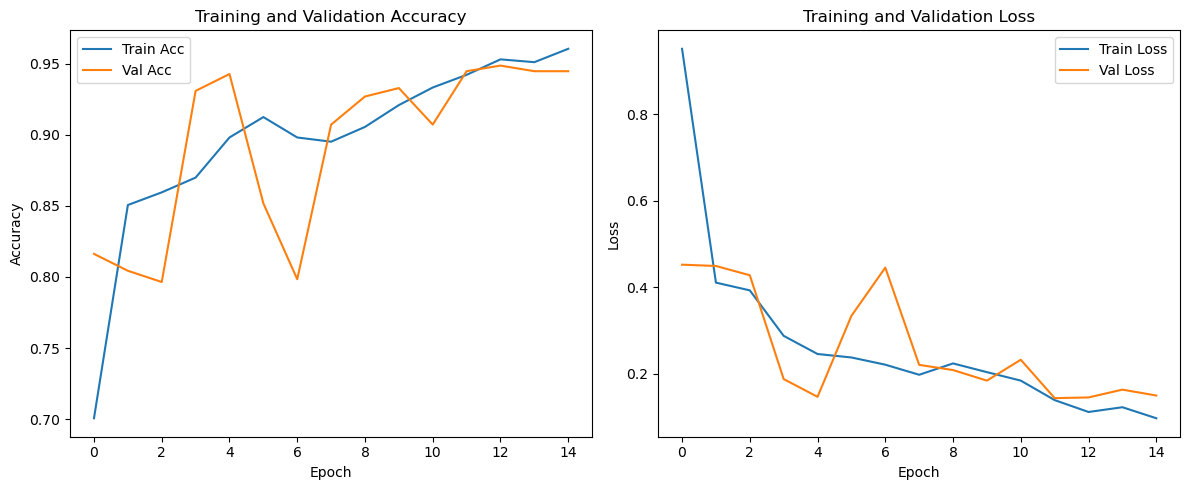

In [13]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.savefig("training_plots.png")
print("\n📊 Training plots saved as 'training_plots.png'")
plt.show()

In [16]:
for images, labels in val_ds.take(1):
    print("Label shape:", labels.shape)

Label shape: (32,)


In [20]:
sample = next(iter(val_ds))
print("Label shape:", sample[1].shape)
print("Label values:", sample[1].numpy())

print("Prediction shape:", model.predict(sample[0]).shape)

Label shape: (32,)
Label values: [1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1]
1/1 [==============================] - 8s 8s/step
Prediction shape: (32, 6)


In [22]:
import tensorflow as tf
from tensorflow.keras import metrics
import numpy as np

model.save("recycle_classifier_optimized.h5")
print("Model saved successfully")

class MultiClassEvaluator:
    def __init__(self):
        self.accuracy = metrics.SparseCategoricalAccuracy()
        self.precision = metrics.Precision()
        self.recall = metrics.Recall()
        
    def update_state(self, y_true, y_pred):
        y_pred_labels = tf.argmax(y_pred, axis=-1)
        
        self.accuracy.update_state(y_true, y_pred)
        
        y_true_onehot = tf.one_hot(y_true, depth=6)
        y_pred_onehot = tf.one_hot(y_pred_labels, depth=6)
        
        self.precision.update_state(y_true_onehot, y_pred_onehot)
        self.recall.update_state(y_true_onehot, y_pred_onehot)
    
    def get_metrics(self):
        return {
            'accuracy': self.accuracy.result().numpy(),
            'precision': self.precision.result().numpy(),
            'recall': self.recall.result().numpy()
        }

def evaluate_model(model, dataset):
    evaluator = MultiClassEvaluator()
    
    for images, labels in dataset:
        predictions = model.predict(images, verbose=0)
        evaluator.update_state(labels, predictions)
    
    metrics = evaluator.get_metrics()
    return metrics

print("\nFinal Evaluation:")
metrics = evaluate_model(model, val_ds)

print(f"Validation Accuracy: {metrics['accuracy']:.4f}")
print(f"Validation Precision: {metrics['precision']:.4f}")
print(f"Validation Recall: {metrics['recall']:.4f}")

Model saved successfully

Final Evaluation:
Validation Accuracy: 0.9447
Validation Precision: 0.9447
Validation Recall: 0.9447


In [25]:
def predict_garbage(image_path, model, threshold=0.5):

    class_names = {
        0: 'cardboard',
        1: 'glass',
        2: 'metal',
        3: 'paper',
        4: 'plastic',
        5: 'trash'
    }
    DISPOSAL_GUIDE = {
        'cardboard': 'Flatten and remove tape',
        'glass': 'Rinse and remove lids',
        'metal': 'Clean cans before recycling',
        'paper': 'Keep dry and remove staples',
        'plastic': 'Check resin code (#1-7) and rinse',
        'trash': 'Place in general waste bin'
    }
    try:
        img = Image.open(image_path).convert('RGB').resize((224, 224))
        img_array = np.array(img)
        img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
        img_array = np.expand_dims(img_array, axis=0)

        predictions = model.predict(img_array)[0]
        class_idx = np.argmax(predictions)
        confidence = float(predictions[class_idx])
        material = class_names[class_idx]

        result = {
            'material': material,
            'confidence': confidence,
            'disposal': DISPOSAL_GUIDE[material],
            'is_recyclable': material != 'trash'
        }

        print("\nPrediction Results:")
        print(f"Material: {material.upper()}")
        print(f"Confidence: {confidence*100:.1f}%")
        print(f"Class: {'RECYCLABLE' if result['is_recyclable'] else 'TRASH'}")
        print("\nProper Disposal:" , "Dispose according to local guidelines")
        print(result['disposal'])

    except Exception as e:
        error_msg = f"Error: {str(e)}"
        print(error_msg)
        return {'error': error_msg}

In [26]:
dataset_predicted = predict_garbage("E:/Codes/Garbage Classification/dataset-resized/non_recyclable/trash/trash87.jpg"
                    , model)
dataset_predicted

1/1 [==============================] - 0s 390ms/step

Prediction Results:
Material: CARDBOARD
Confidence: 84.3%
Class: RECYCLABLE

Proper Disposal: Dispose according to local guidelines
Flatten and remove tape


In [27]:
dataset_predicted = predict_garbage("E:/Codes/Garbage Classification/dataset-resized/recyclable/plastic/plastic14.jpg"
                    , model)
dataset_predicted

1/1 [==============================] - 0s 149ms/step

Prediction Results:
Material: GLASS
Confidence: 98.9%
Class: RECYCLABLE

Proper Disposal: Dispose according to local guidelines
Rinse and remove lids


In [28]:
dataset_predicted = predict_garbage("E:/Codes/Garbage Classification/glass-bottle-or-jar.jpg"
                    , model)
dataset_predicted

1/1 [==============================] - 0s 126ms/step

Prediction Results:
Material: GLASS
Confidence: 99.9%
Class: RECYCLABLE

Proper Disposal: Dispose according to local guidelines
Rinse and remove lids


In [29]:
def interactive_prediction(model):
    print("\nAdvanced Garbage Classifier")
    print("Enter image path or 'quit' to exit")
    
    while True:
        try:
            image_path = input("\nImage path: ").strip().strip('"').strip("'")
        
            if image_path.lower() in ('quit', 'exit', 'q'):
                print("Exiting classifier...")
                break
            
            if not os.path.exists(image_path):
                print("Error: File not found")
                continue
            
            result = predict_garbage(image_path, model)
        
            if 'error' in result:
                print(f"Prediction Error: {result['error']}")
            else:
                print("\n=== Prediction Result ===")
                print(f"Classification: {result['class']}")
                print(f"Material Type: {result['material'].upper()}")
                print(f"Confidence: {result['confidence']*100:.1f}%")
                print("\nDisposal Instructions:")
                print(result['proper_disposal'])
            
        except Exception as e:
            print(f"Unexpected error: {str(e)}")
            print("Please try another image or check the file format.")

In [30]:
interactive_prediction(model)


Advanced Garbage Classifier
Enter image path or 'quit' to exit
1/1 [==============================] - 0s 122ms/step

Prediction Results:
Material: GLASS
Confidence: 99.9%
Class: RECYCLABLE

Proper Disposal: Dispose according to local guidelines
Rinse and remove lids
Unexpected error: argument of type 'NoneType' is not iterable
Please try another image or check the file format.
Exiting classifier...


In [37]:
from tensorflow.keras.models import load_model
from tensorflow.keras import metrics
from PIL import Image
import numpy as np
import tensorflow as tf

class MultiClassMetrics(metrics.Metric):
    def __init__(self, name='multiclass_metrics', **kwargs):
        super().__init__(name=name, **kwargs)
        self.acc = metrics.SparseCategoricalAccuracy(name='accuracy')
        self.prec = metrics.Precision(name='precision')
        self.rec = metrics.Recall(name='recall')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_labels = tf.argmax(y_pred, axis=-1)
        y_true_onehot = tf.one_hot(y_true, depth=6)
        y_pred_onehot = tf.one_hot(y_pred_labels, depth=6)
        self.acc.update_state(y_true, y_pred)
        self.prec.update_state(y_true_onehot, y_pred_onehot)
        self.rec.update_state(y_true_onehot, y_pred_onehot)
    
    def result(self):
        return [self.acc.result(), self.prec.result(), self.rec.result()]

try:
    model = load_model('recycle_classifier_optimized.h5', custom_objects={'MultiClassMetrics': MultiClassMetrics})
    print("Model loaded")
except Exception as e:
    print(f"Load error: {str(e)}")
    exit()

def predict(image_path):
    try:
        img = Image.open(image_path).convert('RGB').resize((224, 224))
        img_array = tf.keras.applications.mobilenet_v2.preprocess_input(np.expand_dims(np.array(img), axis=0))
        pred = model.predict(img_array, verbose=0)[0]
        class_idx = np.argmax(pred)
        materials = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
        disposal = {
            'cardboard': 'Flatten and remove tape',
            'glass': 'Rinse and remove lids',
            'metal': 'Clean cans before recycling',
            'paper': 'Keep dry and remove staples',
            'plastic': 'Check resin code (#1-7) and rinse',
            'trash': 'General waste bin'
        }
        return {
            'class': 'RECYCLABLE' if materials[class_idx] != 'trash' else 'TRASH',
            'material': materials[class_idx],
            'confidence': float(pred[class_idx]),
            'disposal': disposal.get(materials[class_idx], 'Check local guidelines')
        }
    except Exception as e:
        return {'error': str(e)}

result = predict("E:/Codes/Garbage Classification/dataset-resized/recyclable/plastic/plastic14.jpg")
print(f"""
Classification: {result['class']}
Material: {result['material']}
Confidence: {result['confidence']*100:.1f}%
Disposal: {result['disposal']}
""")

Model loaded

Classification: RECYCLABLE
Material: glass
Confidence: 98.9%
Disposal: Rinse and remove lids



In [38]:
from tensorflow.keras.models import load_model
from tensorflow.keras import metrics
from PIL import Image
import numpy as np
import tensorflow as tf

class MultiClassMetrics(metrics.Metric):
    def __init__(self, name='multiclass_metrics', **kwargs):
        super().__init__(name=name, **kwargs)
        self.acc = metrics.SparseCategoricalAccuracy(name='accuracy')
        self.prec = metrics.Precision(name='precision')
        self.rec = metrics.Recall(name='recall')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_labels = tf.argmax(y_pred, axis=-1)
        y_true_onehot = tf.one_hot(y_true, depth=6)
        y_pred_onehot = tf.one_hot(y_pred_labels, depth=6)
        self.acc.update_state(y_true, y_pred)
        self.prec.update_state(y_true_onehot, y_pred_onehot)
        self.rec.update_state(y_true_onehot, y_pred_onehot)
    
    def result(self):
        return [self.acc.result(), self.prec.result(), self.rec.result()]

try:
    model = load_model('recycle_classifier_optimized.h5', custom_objects={'MultiClassMetrics': MultiClassMetrics})
    print("Model loaded successfully")
except Exception as e:
    print(f"Model loading failed: {str(e)}")
    exit()

def predict(image_path):
    try:
        img = Image.open(image_path).convert('RGB').resize((224, 224))
        img_array = tf.keras.applications.mobilenet_v2.preprocess_input(np.expand_dims(np.array(img), axis=0))
        pred = model.predict(img_array, verbose=0)[0]
        class_idx = np.argmax(pred)
        materials = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
        disposal_guide = {
            'cardboard': 'Flatten and remove tape',
            'glass': 'Rinse and remove lids',
            'metal': 'Clean cans before recycling',
            'paper': 'Keep dry and remove staples',
            'plastic': 'Check resin code (#1-7) and rinse',
            'trash': 'General waste bin'
        }
        return {
            'class': 'RECYCLABLE' if materials[class_idx] != 'trash' else 'TRASH',
            'material': materials[class_idx],
            'confidence': float(pred[class_idx]),
            'disposal': disposal_guide.get(materials[class_idx], 'Check local guidelines')
        }
    except Exception as e:
        print(f"Prediction error: {str(e)}")
        return None

result = predict("E:/Codes/Garbage Classification/dataset-resized/recyclable/plastic/plastic14.jpg")
if result:
    print(f"""
Classification: {result['class']}
Material: {result['material']}
Confidence: {result['confidence']*100:.1f}%
Disposal: {result['disposal']}
""")
else:
    print("Prediction failed - check error message above")

Model loaded successfully

Classification: RECYCLABLE
Material: glass
Confidence: 98.9%
Disposal: Rinse and remove lids



In [40]:
import numpy as np
from PIL import Image
import tensorflow as tf

# Load test image
img = Image.open("E:/Codes/Garbage Classification/dataset-resized/recyclable/plastic/plastic14.jpg").convert('RGB').resize((224, 224))
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(np.expand_dims(np.array(img), axis=0))

# Get raw predictions
raw_pred = model.predict(img_array)
print("Raw predictions:", raw_pred)
print("Predicted class index:", np.argmax(raw_pred))
print("Confidence:", np.max(raw_pred))

1/1 [==============================] - 0s 305ms/step
Raw predictions: [[1.0933237e-02 9.8905164e-01 4.2954243e-06 5.7287539e-06 1.3047850e-06
  3.8234839e-06]]
Predicted class index: 1
Confidence: 0.98905164


In [41]:
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
print("Predicted material:", class_names[np.argmax(raw_pred)])

Predicted material: glass


In [42]:
print("Image array stats:")
print("Min:", np.min(img_array))
print("Max:", np.max(img_array))
print("Mean:", np.mean(img_array))
print("Shape:", img_array.shape)

Image array stats:
Min: -1.0
Max: 0.9843137
Mean: 0.38694534
Shape: (1, 224, 224, 3)


In [47]:
test_images = {
    'plastic': "E:/Codes/Garbage Classification/dataset-resized/recyclable/plastic/plastic14.jpg",
    'glass': "E:/Codes/Garbage Classification/dataset-resized/recyclable/glass/glass17.jpg",
    'metal': "E:/Codes/Garbage Classification/dataset-resized/recyclable/metal/metal19.jpg",
    'trash': "E:/Codes/Garbage Classification/dataset-resized/non_recyclable/trash/trash31.jpg"
}

for true_class, path in test_images.items():
    try:
        img = Image.open(path).convert('RGB').resize((224, 224))
        img_array = tf.keras.applications.mobilenet_v2.preprocess_input(np.expand_dims(np.array(img), axis=0))
        pred = model.predict(img_array)
        predicted_class = class_names[np.argmax(pred)]
        confidence = np.max(pred)
        print(f"\n{path} (True: {true_class})")
        print(f"Predicted: {predicted_class} ({confidence:.2%})")
        print("All class confidences:")
        for name, conf in zip(class_names, pred[0]):
            print(f"- {name}: {conf:.2%}")
    except Exception as e:
        print(f"Error testing {path}: {str(e)}")

1/1 [==============================] - 0s 167ms/step

E:/Codes/Garbage Classification/dataset-resized/recyclable/plastic/plastic14.jpg (True: plastic)
Predicted: glass (98.91%)
All class confidences:
- cardboard: 1.09%
- glass: 98.91%
- metal: 0.00%
- paper: 0.00%
- plastic: 0.00%
- trash: 0.00%
1/1 [==============================] - 0s 175ms/step

E:/Codes/Garbage Classification/dataset-resized/recyclable/glass/glass17.jpg (True: glass)
Predicted: glass (99.79%)
All class confidences:
- cardboard: 0.20%
- glass: 99.79%
- metal: 0.00%
- paper: 0.00%
- plastic: 0.00%
- trash: 0.00%
1/1 [==============================] - 0s 229ms/step

E:/Codes/Garbage Classification/dataset-resized/recyclable/metal/metal19.jpg (True: metal)
Predicted: glass (99.97%)
All class confidences:
- cardboard: 0.03%
- glass: 99.97%
- metal: 0.00%
- paper: 0.00%
- plastic: 0.00%
- trash: 0.00%
1/1 [==============================] - 0s 117ms/step

E:/Codes/Garbage Classification/dataset-resized/non_recyclable/tras

In [48]:
import os
from collections import Counter

dataset_path = "E:/Codes/Garbage Classification/dataset-resized"
class_counts = Counter()

for root, dirs, files in os.walk(dataset_path):
    if os.path.basename(root) in ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']:
        class_counts[os.path.basename(root)] += len(files)

print("Class distribution:")
for cls, count in class_counts.items():
    print(f"{cls}: {count} images")

Class distribution:
trash: 137 images
cardboard: 403 images
glass: 501 images
metal: 410 images
paper: 594 images
plastic: 482 images
